Imports

In [1]:
# numpy is the standard python array / vector library. We will use it to represent probabilities
import numpy as np
import scipy
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

### <b>1. The Bayesian Brain: Action-Perception-Loop</b>

The brain is in constant interaction with its environment. 

<img src="Action_Perception_Loop.png" width="600"/>

The environment (including the body) is typically thought to be in a specific state, or you are in a specific state within this environment. Examples inlcude the position and velocity of a ball that you throw, or your position in a city that you're trying to navigate in. Both are not directly observable, as the only information that the brain has direct access to is the sensory input, e.g. the pixel pattern on the retina. From this, the brain needs to *infer* where the ball likely is given some visual image of the ball, or at which intersection of the city you are, given the buildings and trees that you see. Additionally, you can also infer future states, like for example where the ball that is currently in the air will land, using known rules, like for example the laws of physics.

But the brain has not only input to make sense of, but is also in a position to act, and enact changes in the environment. To do this, the brain encodes consequences of actions as well. This allows us predict how our actions may change the hidden state of the environment. We can use this prediction and compare it to our goals, to figure out which actions to actually execute.


For this workshop, we use a specific example to explore the process of perception and action as Bayesian inference. We will use Sarah's cat Schmüffie (see below) as the environment. 

<img src="Schmueffie_Loop.png" width="600"/>

(Un?)fortunately Schmüffie can not speak, and her face also often doesn't portray her inner workings well. However, we can *infer* how she is feeling, given her actions and reactions to us.

For this example, let us assume there are only two possible states, outcomes and actions:
* Possible states are "good" and "bad" mood
* Possible observations are "purr" and "walk away"
* Possible actions are "pet" and "carry around"

#### <b>1.1. The generative model</b>

The main idea in the Bayesian brain hypothesis is that the brain learns the rules of how observations are related to states, and how states may change as probability distributions in the form of a generative model. In this notebook we will take a deeper look into the different parts of the generative model, as they will also all give information about contexts; and use this model to infer what Schmüffies mood is, and what we should do to improve her mood.

<img src="Generative_Model.png" width="200"/>

Concretely, the exemplary generative model that we will look at has two time steps, one is time step $t$, now, and one is the next future time step $t+1$. We have one state and observation at each time step, and one action in between time steps, which may change the state. Therefore we have:
* the state now $s_{t}$ and the state in the future $s_{t+1}$, both can either be "good" or "bad".
* the observation now $o_{t}$ and the observation in the future $o_{t+1}$, both can be either "purr" or "walk away"
* and an action that we can enact now $a_{t}$ that can be either "pet" or "carry around".

These variables are specified and connected as shown below. Note that in the generative model the arrows follow the actual causality in the environment, i.e. a state causes an observation. Inference will be used to make the inverse reasoning (which state caused the observation?).

<img src="State_prior_gen_mod.png" width="213"/><img src="Observation_likelihood_gen_mod.png" width="200"/><img src="State_transition_gen_mod.png" width="200"/>

For now, the model has three main parts, which will be introduced in more detail below:

* A prior over the first state $s_{t}$ that tells us, without having collected any further information, how likely Schmüffie typically is in einer a "good" or "bad" mood (see also 1.2.).
* An observation likelihood that connects the hidden states $s_{t}$ and $s_{t+1}$ to the observations $o_{t}$ and $o_{t+1}$, i.e. what's the likelihood of a specific observation given a specific state (see also 1.3.)
* A state transition probability that connects the current state $s_{t}$ and the action $a_{t}$ to possible future states and their probabilities (see also 1.6.)

#### <b>1.2. The state prior</b>

 <img src="State_in_loop.png" width="600"/> 

The state $s_{t}$ is shown in yellow in the generative model below

 <img src="The_Prior.png" width="200"/>

In our example, the states $s_{t}$ corresponds to Schmüffies current mood at the current time step $t$.

<b>The prior</b> over the current state $$p(s_{t})$$ encodes our a priori information about the state, which we have already before interacting witht the system (i.e. Schmüffie). Is Schmüffie a generally happy cat or not? She mostly is, but sometimes she is sick or for other reasons in a bad mood, so for this example we assign $75\%$ to her being in a good mood a priori, and $25\%$ to her being in a bad mood.

Note, that such a prior reflects our knowledge at a given time, that we have learned from previous experience. In discrete variables, Bayesian learning corresponds to keeping count of how often we have seen one over the other state. For example, I may have seen Schmüffie in a good mood on 300 days, but in a bad mood in 100 days, over me knowing her for 300+100=400 days. This yields the probabilities above as $$\frac{\text{Number of good days}}{\text{Total number of days}}=\frac{300}{400}=0.75 \quad\text{and}\quad\frac{\text{Number of bad days}}{\text{Total number of days}}=\frac{100}{400}=0.25$$

Mathematicaly, the prior $p(s_{t})$ over states can be understood as a probability vector that assigns each of the possible states {good, bad} a probability
$$p(s_{t}) = \begin{pmatrix} p(s_{t}=\text{good})\\p(s_{t}=\text{bad}) \end{pmatrix}$$
e.g. as in our example above
$$p(s_{t}) = \begin{pmatrix} 0.75\\0.25 \end{pmatrix}$$
which is equivalent to saying
$$p(s_{t}=\text{good})=0.75, \quad p(s_{t}=\text{bad})=0.25$$
To mentally keep track what each entry means, it can be practical to write it next to the vector (or matrices later)
$$p(s_{t}) = \begin{pmatrix} 0.75\\0.25 \end{pmatrix} \begin{matrix} \text{good}\\ \text{bad}\end{matrix}$$

Below we implement this in python code

In [2]:
# we use the standard python array library numpy to represent the vector as an array

prior_states = np.array([0.75, 0.25])

print("this is the prior over states")
print(prior_states)

this is the prior over states
[0.75 0.25]


And plot the values

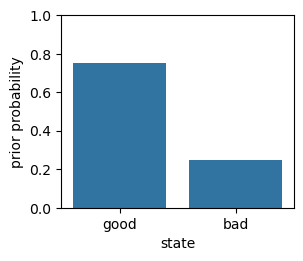

In [3]:
plot_prior = pd.DataFrame({"state": ["good", "bad"], "prior probability": prior_states})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_prior, x="state", y="prior probability")
plt.ylim([0,1])
plt.show()

#### <b>1.3. The observation likelihood</b>

 <img src="Observation_in_loop.png" width="600"/> 

The observation likelihood corresponds to the yellow arrow and $o_{t}$ in the generative model below

 <img src="The_Likelihood.png" width="200"/>

Here, we define the likelihood of different observations that we can perceive, if Schmüffie is in a certain state, e.g. what's the likelihood of her purring given (usually written as a | symbol) she is in a good mood $p(o_{t}=\text{purr}|s_{t}=\text{good})$?

The possible outcomes and their probabilities can again be understood as probability vectors, given a specific state. The probability vector for the state "good mood" is in our example
$$p(o_{t}|s_{t}=\text{good}) = \begin{pmatrix} 0.9\\ 0.1 \end{pmatrix} \begin{matrix}\text{purr}\\ \text{walk away}\end{matrix}$$
and the probability vector for the state "bad mood" is
$$p(o_{t}|s_{t}=\text{bad}) = \begin{pmatrix} 0.2\\ 0.8 \end{pmatrix} \begin{matrix}\text{purr}\\ \text{walk away}\end{matrix}$$

The two observation likelihood vectors can be written together in matrix / table, by writing them next to each other:
$$ p(o_{t}|s_{t})=\begin{pmatrix} 0.9 & 0.2\\ 0.1 & 0.8 \end{pmatrix}$$
Here one dimension (left to right) corresponds to the input (what state is she in?) and one dimension (up to down) to the output (what is her reaction that we can perceive?).

It can again be helpful to write the meaning of each row / column next to the matrix
$$ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{state:} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ \textbf{observation:}\begin{matrix}\text{purr}\\ \text{walk away}\end{matrix}\begin{pmatrix} 0.9 & 0.2\\ 0.1 & 0.8 \end{pmatrix}$$

Also notice that the rows are normalized, but the columns are not!

In [4]:
# now we write the matrix in code
# Note that python indexes from 0, so observation_likelihood[0] is purr, and [1] is walk

observation_likelihood = np.array([[0.9, 0.2], 
                                   [0.1, 0.8]])

print("observation likelihood")
print(observation_likelihood)

observation likelihood
[[0.9 0.2]
 [0.1 0.8]]


And we can plot the values for both states

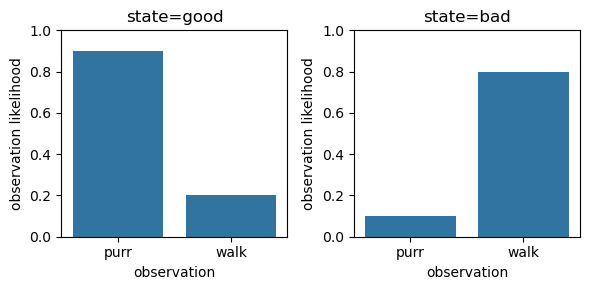

In [5]:
plot_obs_like_good = pd.DataFrame({"observation": ["purr", "walk"], "observation likelihood": observation_likelihood[0]})
plot_obs_like_bad = pd.DataFrame({"observation": ["purr", "walk"], "observation likelihood": observation_likelihood[1]})

fig, ax = plt.subplots(ncols=2,figsize=[6,3])
sns.barplot(data=plot_obs_like_good, x="observation", y="observation likelihood", ax=ax[0])
ax[0].set_ylim([0,1])
ax[0].set_title("state=good")
sns.barplot(data=plot_obs_like_bad, x="observation", y="observation likelihood", ax=ax[1])
ax[1].set_ylim([0,1])
ax[1].set_title("state=bad")
plt.tight_layout()
plt.show()

#### <b>1.4. Perception as inference</b>

 <img src="Perception_in_loop_bubble.png" width="650"/> 

This process corresponds to using our knowledge above about prior and likelihood to calculate the posterior over states, as depicted in yellow below

 <img src="Inference_gen_mod.png" width="200"/>

Here, we try to answer the question "if I perceived purring, what was Schmüffie's mood?"

Bayes' theorem allows us to use the knowldge above and invert it to draw this conclusion:

$$p(s_{t}|o_{t}) = \frac{p(o_{t}|s_{t})p(s_{t})}{p(o_{t})} \propto p(o_{t}|s_{t})p(s_{t})$$

So we can use both, the prior over states and the observation likelihood to infer the posterior probability of states given a certain observation. Importantly, in the case of discrete variables like we have in our example, the evidence $p(o_{t})$ in Bayes' theorem can be ignored for now, as we can just re-normalize the result (divide each entry by the sum of both of them, so that the sum of the result is 1).

As an example, let's say we have observed purring, that means we are calculating the following posterior
$$p(s_{t}|o_{t}=\text{purr}) \propto p(o_{t}=\text{purr}|s_{t})p(s_{t})$$

For this we can use the row in the observation likelihood that corresponds to purring
$$p(o_{t}=\text{purr}|s_{t}) = \begin{pmatrix} 0.9 & 0.2\end{pmatrix}$$
which told us how likely it is that Schmüffie purrs in each state. Note that this is not normalized.

We can multiply this with the prior probabilities of the states to get the unnormalized posterior over states:
$$p(s_{t}|o_{t}=\text{purr}) \propto \begin{pmatrix} 0.9*0.75 & 0.2*0.25\end{pmatrix}$$

Let's see using code what the posterior for this is

In [6]:
# since purr was the upper row, and python indexes from 0, the purr row is index 0
# if we want to make sure that this is correct, we can print the row
print("observation likelihood for purring")
print(observation_likelihood[0])

# multiply row with prior
unnormalized_posterior_states_purr = observation_likelihood[0] * prior_states

print("unnormalized posterior states for observation purring")
print(unnormalized_posterior_states_purr)

# and in order to get a probability of each state, we normalize this
posterior_states_purr = unnormalized_posterior_states_purr / unnormalized_posterior_states_purr.sum()

print("normalized posterior over states for observation purring")
print(posterior_states_purr)

observation likelihood for purring
[0.9 0.2]
unnormalized posterior states for observation purring
[0.675 0.05 ]
normalized posterior over states for observation purring
[0.93103448 0.06896552]


And plot the values

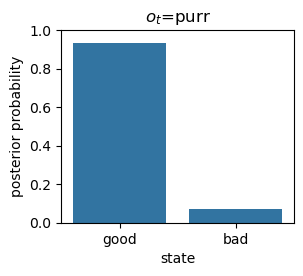

In [7]:
plot_posterior_purr = pd.DataFrame({"state": ["good", "bad"], "posterior probability": posterior_states_purr})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_posterior_purr, x="state", y="posterior probability")
plt.ylim([0,1])
plt.title("$o_{t}$=purr")
plt.show()

So our posterior over states after having seen "purr" is
$$p(s_{t}|o_{t}=\text{purr})=\begin{pmatrix} 0.93 & 0.07\end{pmatrix}$$

So we can be reasonably certain that Schmüffie's mood when she is purring is pretty good :)

We can apply the same operation for the case when we perceived "walking away"

$$p(s_{t}|o_{t}=\text{walk away}) \propto \begin{pmatrix} 0.1*0.75 & 0.8*0.25\end{pmatrix}$$

In [8]:
# posterior over states for "walk away"

# use index 1 to get walk away row
print("observation likelihood for walk away")
print(observation_likelihood[1])

# multiply row with prior
unnormalized_posterior_states_walk = observation_likelihood[1] * prior_states

print("unnormalized posterior states for observation walk away")
print(unnormalized_posterior_states_walk)

# and in order to get a probability of each state, we normalize this
posterior_states_walk = unnormalized_posterior_states_walk / unnormalized_posterior_states_walk.sum()

print("normalized posterior over states for observation walk away")
print(posterior_states_walk)

observation likelihood for walk away
[0.1 0.8]
unnormalized posterior states for observation walk away
[0.075 0.2  ]
normalized posterior over states for observation walk away
[0.27272727 0.72727273]


And plot the values

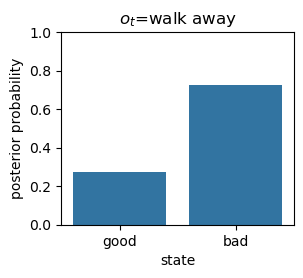

In [9]:
plot_posterior_walk = pd.DataFrame({"state": ["good", "bad"], "posterior probability": posterior_states_walk})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_posterior_walk, x="state", y="posterior probability")
plt.ylim([0,1])
plt.title("$o_{t}$=walk away")
plt.show()

So our posterior over states after having seen "walk away" is
$$p(s_{t}|o_{t}=\text{walk away})=\begin{pmatrix} 0.27 & 0.73\end{pmatrix}$$

Here, the picture is not quite as clear, when she's walking away, she is likely in a bad mood, but maybe she's also just being a cat.

#### <b>1.5. Actions and their consequences</b>

 <img src="Action_in_loop.png" width="600"/> 

Actions and their consequences are represented as state transitions, as depicted below in yellow

 <img src="The_State_Transition.png" width="200"/>

It is typically assumed that actions have probabilistic outcomes in the form of state transitions. State transitions are typically defined similarly to the observation likelihood above, where there is a matrix of probabilities with one dimension is the input state $s_{t}$ and one dimension is the output state $s_{t+1}$ at the next time step $t+1$.

For our possible actions {pet, carry}, the action pet could have the following state transition matrix (Schmüffie likes pets)
$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{previous state $s_{t}$} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(s_{t+1}|s_{t},a_{t}=\text{pet}) = \textbf{new state $s_{t+1}$}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.99 & 0.6\\ 0.01 & 0.4 \end{pmatrix}$$

However, Schmüffie does not like being carried around, so this action could have the following state transition matrix
$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{previous state $s_{t}$} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(s_{t+1}|s_{t},a_{t}=\text{carry}) = \textbf{new state $s_{t+1}$}\,\begin{matrix}\text{good}\\ \text{bad}\end{matrix}\begin{pmatrix} 0.3 & 0.1\\ 0.7 & 0.9 \end{pmatrix}$$

In [10]:
# the action-dependent state-transition matrix

state_transition_matrix = np.array([
    [[0.99, 0.6],
     [0.01, 0.4]],
    [[0.3, 0.1],
     [0.7, 0.9]]
])

print("state transition matrix for action pet")
print(state_transition_matrix[0,:,:])

print("state transition matrix for action carry")
print(state_transition_matrix[1,:,:])

state transition matrix for action pet
[[0.99 0.6 ]
 [0.01 0.4 ]]
state transition matrix for action carry
[[0.3 0.1]
 [0.7 0.9]]


#### <b>1.6. Prediction and planning</b>

 <img src="Prediction_in_loop.png" width="600"/> 

Together with the posterior over states, the action-dependent state transition matrices can be used to predict future states and observations for the different actions.

<b>1.6.1. Predicting states</b>

 <img src="Prediction_gen_mod.png" width="200"/>

As a first prediction example, let us look at our predictions after having seen "purr", and what we predict to happen after doing the action "pet": 

1. We have inferred a posterior over current states (see above in 1.4.), given what we have observed ("purr") $p(s_{t}|o_{t}=\text{purr})=\begin{pmatrix} 0.93\\ 0.07\end{pmatrix}$
2. We know how the state will change when we execute either pet via the state transition matrix $p(s_{t+1}|s_{t},a_{t}=\text{pet})=\begin{pmatrix} 0.99 & 0.6\\ 0.01 & 0.4 \end{pmatrix}$

We can use matrix multiplication to get a posterior over the future state $p(s_{t}|o_{t}=\text{purr},a_{t}=\text{pet})=\sum_{s_{t}}p(s_{t+1}|s_{t},a_{t}=\text{pet})p(s_{t}|o_{t}=\text{purr})$

$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{pmatrix} 0.93& 0.07\end{pmatrix}\\p(s_{t}|o_{t}=\text{purr},a_{t}=\text{pet})=\begin{pmatrix} 0.99 & 0.6\\ 0.01 & 0.4 \end{pmatrix}$$

Let's see what comes out

In [11]:
# use the numpy matrix multiplication feature "dot"

posterior_future_state_pet_purr = np.dot(state_transition_matrix[0,:,:], posterior_states_purr)

print("posterior over future states after observing purr and doing pet")
print(posterior_future_state_pet_purr)

posterior over future states after observing purr and doing pet
[0.96310345 0.03689655]


And plot the values

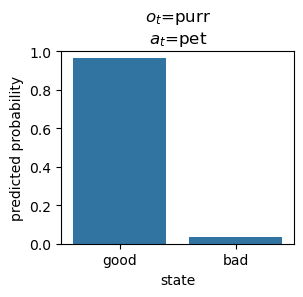

In [12]:
plot_future_state_pet_purr = pd.DataFrame({"state": ["good", "bad"], "predicted probability": posterior_future_state_pet_purr})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_future_state_pet_purr, x="state", y="predicted probability")
plt.ylim([0,1])
plt.title("$o_{t}$=purr\n$a_{t}$=pet")
plt.show()

Our predicted state probabilities after the action "pet" are
$p(s_{t+1}|s_{t}, o_{t}=\text{purr}, a_{t}=\text{pet}) = \begin{pmatrix} 0.96\\ 0.04 \end{pmatrix} \begin{matrix}\text{good}\\ \text{bad}\end{matrix}$

So, given our knowledge about Schmüffie and that she was just purring, we predicted that petting her now will lead to her being in a good mood with 96% chance. This comes from either her already being in a good mood and staying in a good mood, or from getting her into a good mood.

We can do similarly for the action carry which has the transition matrix is $p(s_{t+1}|s_{t},a_{t}=\text{carry})=\begin{pmatrix} 0.3 & 0.1\\ 0.7 & 0.9 \end{pmatrix}$

In [13]:
posterior_future_state_carry_purr = np.dot(state_transition_matrix[1,:,:], posterior_states_purr)

print("posterior over future states after observing purr and doing carry")
print(posterior_future_state_carry_purr)

posterior over future states after observing purr and doing carry
[0.2862069 0.7137931]


And plot the values

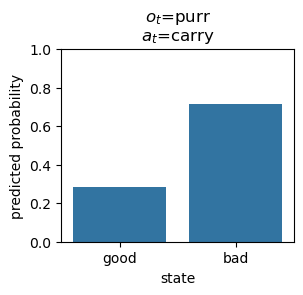

In [14]:
plot_future_state_carry_purr = pd.DataFrame({"state": ["good", "bad"], "predicted probability": posterior_future_state_carry_purr})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_future_state_carry_purr, x="state", y="predicted probability")
plt.ylim([0,1])
plt.title("$o_{t}$=purr\n$a_{t}$=carry")
plt.show()

Our predicted state probabilities after the action "carry" are
$p(s_{t+1}|s_{t}, o_{t}=\text{purr}, a_{t}=\text{carry}) = \begin{pmatrix} 0.28\\ 0.71 \end{pmatrix} \begin{matrix}\text{good}\\ \text{bad}\end{matrix}$

So, if we were to carry her, we would make her mood bad with 71% chance, either from her already having been in a bad mood, or from ruining her good mood.

We can do the same thing for having seen "walk away":

In [15]:
posterior_future_state_pet_walk = np.dot(state_transition_matrix[0,:,:], posterior_states_walk)

print("posterior over future states after observing walk away and doing pet")
print(posterior_future_state_pet_walk)

posterior over future states after observing walk away and doing pet
[0.70636364 0.29363636]


And plot the values

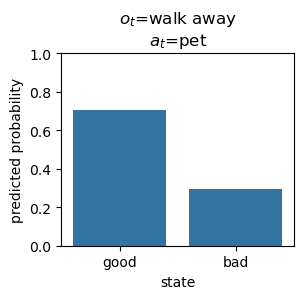

In [16]:
plot_future_state_pet_walk = pd.DataFrame({"state": ["good", "bad"], "predicted probability": posterior_future_state_pet_walk})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_future_state_pet_walk, x="state", y="predicted probability")
plt.ylim([0,1])
plt.title("$o_{t}$=walk away\n$a_{t}$=pet")
plt.show()

Our predicted state probabilities after the action "pet" are
$p(s_{t+1}|s_{t}, o_{t}=\text{walk away}, a_{t}=\text{pet}) = \begin{pmatrix} 0.71\\ 0.29 \end{pmatrix} \begin{matrix}\text{good}\\ \text{bad}\end{matrix}$

Given our knowledge about Schmüffie and that she was just walking, we can predict that petting her now will lead to her being in a good mood with 71% chance. 

We can do similarly for the action carry:

In [17]:
posterior_future_state_carry_walk = np.dot(state_transition_matrix[1,:,:], posterior_states_walk)

print("posterior over future states after observing walk away and doing carry")
print(posterior_future_state_carry_walk)

posterior over future states after observing walk away and doing carry
[0.15454545 0.84545455]


And plot the values

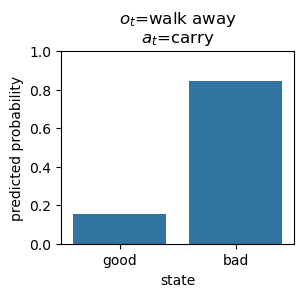

In [18]:
plot_future_state_carry_walk = pd.DataFrame({"state": ["good", "bad"], "predicted probability": posterior_future_state_carry_walk})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_future_state_carry_walk, x="state", y="predicted probability")
plt.ylim([0,1])
plt.title("$o_{t}$=walk away\n$a_{t}$=carry")
plt.show()

Our predicted state probabilities after the action "carry" are
$p(s_{t+1}|s_{t}, o_{t}=\text{walk away}, a_{t}=\text{carry}) = \begin{pmatrix} 0.15\\ 0.85 \end{pmatrix} \begin{matrix}\text{good}\\ \text{bad}\end{matrix}$

Given our knowledge about Schmüffie and that she was just walking, we can picking her up and carrying her will lead to her being in a bad mood with 85% chance. 

<b>1.6.2. Predicting observations</b>

<img src="Prediction_Observervation_gen_mod.png" width="200"/>

We can use the posterior over future states to predict future observations. This again works via using a matrix multiplication of the predicted state with our knowledge about outcome likelihoods.

We can again in do this for all combinations of having seen {purr, walk away} and having done {pet, carry}.

Having seen purr:

In [19]:
posterior_future_observation_pet_purr = np.dot(observation_likelihood, posterior_future_state_pet_purr)

print("posterior over future observations after having observed purr and executed the action pet")
print(posterior_future_observation_pet_purr)

posterior_future_observation_carry_purr = np.dot(observation_likelihood, posterior_future_state_carry_purr)

print("posterior over future observations after having observed purr and executed the action carry")
print(posterior_future_observation_carry_purr)

posterior over future observations after having observed purr and executed the action pet
[0.87417241 0.12582759]
posterior over future observations after having observed purr and executed the action carry
[0.40034483 0.59965517]


And we can plot the values for both possible actions

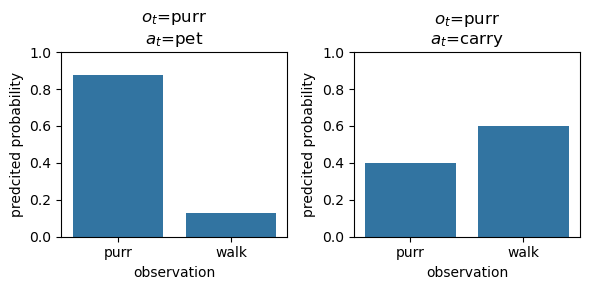

In [20]:
plot_future_obs_pet_purr = pd.DataFrame({"observation": ["purr", "walk"], "predcited probability": posterior_future_observation_pet_purr})
plot_future_obs_carry_purr = pd.DataFrame({"observation": ["purr", "walk"], "predcited probability": posterior_future_observation_carry_purr})

fig, ax = plt.subplots(ncols=2,figsize=[6,3])
sns.barplot(data=plot_future_obs_pet_purr, x="observation", y="predcited probability", ax=ax[0])
ax[0].set_ylim([0,1])
ax[0].set_title("$o_{t}$=purr\n$a_{t}$=pet")
sns.barplot(data=plot_future_obs_carry_purr, x="observation", y="predcited probability", ax=ax[1])
ax[1].set_ylim([0,1])
ax[1].set_title("$o_{t}$=purr\n$a_{t}$=carry")
plt.tight_layout()
plt.show()

Having seen walk away:

In [21]:
posterior_future_observation_pet_walk = np.dot(observation_likelihood, posterior_future_state_pet_walk)

print("posterior over future observations after having observed walk away and executed the action pet")
print(posterior_future_observation_pet_walk)

posterior_future_observation_carry_walk = np.dot(observation_likelihood, posterior_future_state_carry_walk)

print("posterior over future observations after having observed walk away and executed the action carry")
print(posterior_future_observation_carry_walk)

posterior over future observations after having observed walk away and executed the action pet
[0.69445455 0.30554545]
posterior over future observations after having observed walk away and executed the action carry
[0.30818182 0.69181818]


And we can plot the values for both possible actions

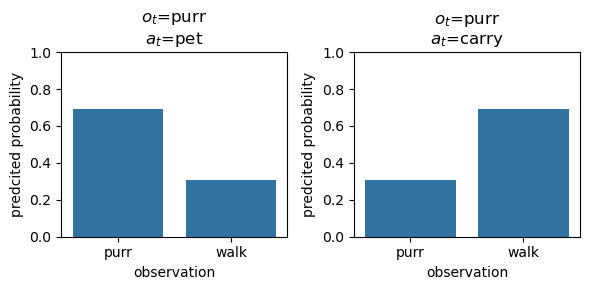

In [22]:
plot_future_obs_pet_walk = pd.DataFrame({"observation": ["purr", "walk"], "predcited probability": posterior_future_observation_pet_walk})
plot_future_obs_carry_walk = pd.DataFrame({"observation": ["purr", "walk"], "predcited probability": posterior_future_observation_carry_walk})

fig, ax = plt.subplots(ncols=2,figsize=[6,3])
sns.barplot(data=plot_future_obs_pet_walk, x="observation", y="predcited probability", ax=ax[0])
ax[0].set_ylim([0,1])
ax[0].set_title("$o_{t}$=purr\n$a_{t}$=pet")
sns.barplot(data=plot_future_obs_carry_walk, x="observation", y="predcited probability", ax=ax[1])
ax[1].set_ylim([0,1])
ax[1].set_title("$o_{t}$=purr\n$a_{t}$=carry")
plt.tight_layout()
plt.show()

After petting, we predict Schmüffie to purr with 87% chance, while we predict her to walk away after carrying her with 60% chance

Note that in practice, only one observation $o_{t}$ has been observed, so predictions only have to be made for one scenario

#### <b>1.7. Goals and planning as inference</b>

Above, we have predicted future states and outcomes for both of our possible actions. But how do we know which is better and what to choose? For this we need a goal, i.e. a desired state or outcome that we want to achieve by executing an action.

<img src="Action_Selection_gen_mod.png" width="200"/>

In the planning as inference framework, goals are encoded by conditioning on a desired state or outcome, similar to when we conditioned above on the actually perceived outcome. Typically an observation is chosen as a condition for action selection, e.g. "purr", as the observation is actually observable. However, it would also be possible to condition on a wanted hidden state, e.g. "good" mood. As an example, we can ask the question, what action should I do, so that I will perceive the purr observation $o_{t+1}$ in the upcoming timestep at $t+1$? 
$$p(a_{t}|o_{t+1}=\text{purr})$$

Additionally, we have to condition on the previously perceived observation, as the decision is supposed to be made based on what you experienced just now, and what state you think you're in. Assuming we just perceived "walk away", it then looks like this:
$$p(a_{t}|o_{t}=\text{walk away}, o_{t+1}=\text{purr})$$

So the question that we will be asking in the following is: If I just experienced "walk away", and I want to make Schmüffie purr, which action should I do and how certain am I on that?

The answer to this has three parts:

1. Infer the current state $s_{t}$ to know where I am at (I may have to act differently if I am in one state or in another), and project it into the future for the possible actions to get a predicted state $s_{t+1}$.

2. Invert the information from the desired outcome to know what the desired state $s_{t+1}$ would be.

3. Map these two onto each other, compare, and select an action $a_{t}$.

<b>1.7.1 State inference and prediction</b>

Here we can luckily re-use the inference and prediction results from above. As a first step evaluate in what state we think we are (calculation and how we got the numbers see in 1.4.)
$$p(s_{t}|o_{t}=\text{walk away})=\begin{pmatrix} 0.27\\ 0.73\end{pmatrix} \begin{matrix} \text{good}\\ \text{bad} \end{matrix}$$

As a second step, we use the prediction method from above, to see how we predict state changes for the different actions (see posterior over future states in 1.6.)
Here we had the following for the two actions:

Our predicted state probabilities after the action "pet" are
$p(s_{t+1}|s_{t}, o_{t}=\text{walk away}, a_{t}=\text{pet}) = \begin{pmatrix} 0.71\\ 0.29 \end{pmatrix} \begin{matrix}\text{good}\\ \text{bad}\end{matrix}$

Our predicted state probabilities after the action "carry" are
$p(s_{t+1}|s_{t}, o_{t}=\text{walk away}, a_{t}=\text{carry}) = \begin{pmatrix} 0.15\\ 0.85 \end{pmatrix} \begin{matrix}\text{good}\\ \text{bad}\end{matrix}$

<b>1.7.2 Desired state</b>

To get from the wanted observation to the action, we also need to figure out what our desired future state is given the wanted observation. To do this, we invert the relationship between the future observation and state by using (part of) Bayes' theorem:
$$p(s_{t+1}|o_{t+1}=\text{purr})\propto p(s_{t+1})p(o_{t+1}=\text{purr}|s_{t+1})$$

We will ignore the prior $p(s_{t+1})$ for now.

Where we can again use our observation likelihood from above as 
$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{state:} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\ p(o_{t+1}|s_{t+1}) = \textbf{observation:}\begin{matrix}\text{purr}\\ \text{walk away}\end{matrix}\begin{pmatrix} 0.9 & 0.2\\ 0.1 & 0.8 \end{pmatrix}$$

We use the "purr" column (the same method as in 1.4., where we conditioned on actually perceiving "purr")$$\quad\quad\quad\quad\quad\quad\quad\quad\quad\textbf{state:} \\ \quad\quad\quad\quad\quad\quad\quad\quad\quad\begin{matrix}\text{good} & \text{bad}\end{matrix}\\p(o_{t+1}=\text{purr}|s_{t+1}) = \begin{pmatrix} 0.9 & 0.2 \end{pmatrix}$$

This is essentially the information that is passed on from the observation onto the state. While this is unnormalized, it is clear that it would be easier to get to "purr" from the state "good" rather than "bad".

<b>1.7.3. Quality of states</b>

Now, we don't actually have a prior over future states, but we do have the action dependent prediction over future states $p(s_{t+1}|o_{t}=\text{walk away}, a_{t})$ that we calculated in 1.7.1. for each action $a_{t}$. So the Bayes equation above reads
$$p(s_{t+1}|o_{t+1}=\text{purr},o_{t}=\text{walk away}, a_{t})\propto p(s_{t+1}|o_{t}=\text{walk away}, a_{t})p(o_{t+1}=\text{purr}|s_{t+1})$$

With this, we can figure out how likely and desriable our predicted future states are given the actions that we could execute, by simply multiplying the two factors.

So we get two prediction of desired states, one for each action respectively:

For the action "pet" we get
$$p(s_{t+1}|o_{t+1}=\text{purr},o_{t}=\text{walk away}, a_{t}=\text{pet})\propto p(s_{t+1}|o_{t}=\text{walk away}, a_{t}=\text{pet})p(o_{t+1}=\text{purr}|s_{t+1})$$
and use the numbers from 1.7.1 and 1.7.2.
$$p(s_{t+1}|o_{t+1}=\text{purr},o_{t}=\text{walk away}, a_{t}=\text{pet})\propto \begin{pmatrix} 0.71 & 0.29 \end{pmatrix} * \begin{pmatrix} 0.9 & 0.2 \end{pmatrix} = \begin{pmatrix} 0.71*0.9 & 0.29*0.2 \end{pmatrix}$$

Note, that when multiplying two sources of information like this, the resulting numbers are high when the two sources agree (e.g. (1 0)\*(1 0)=(1 0)), and lower when they do not (e.g. (0.9 0.1)\*(0.1 0.9)=(0.09 0.09)). 

The sum of these numbers therefore quantifies whether the predicted state and desired state align. It can be interpreted as <b>evidence</b> for or against an action, which is what we will evaluate in the following.

Evidence for the action "pet":

In [23]:
unnormalized_desired_states_pet_walk = posterior_future_state_pet_walk * observation_likelihood[0]

print("unnormalized desired future state when having seen walk away and planning the action pet")
print("note that the smaller the numbers in this, the more were the desired states and predicted states in disagreement")
print(unnormalized_desired_states_pet_walk)

evidence_pet_walk = unnormalized_desired_states_pet_walk.sum()

print("evidence for action pet being desired, after having seen walk away")
print(evidence_pet_walk)

unnormalized desired future state when having seen walk away and planning the action pet
note that the smaller the numbers in this, the more were the desired states and predicted states in disagreement
[0.63572727 0.05872727]
evidence for action pet being desired, after having seen walk away
0.6944545454545454


For the action "carry" we get
$$p(s_{t+1}|o_{t+1}=\text{purr},o_{t}=\text{walk away}, a_{t}=\text{carry})\propto p(s_{t+1}|o_{t}=\text{walk away}, a_{t}=\text{carry})p(o_{t+1}=\text{purr}|s_{t+1})$$
and use the numbers from 1.7.1. and 1.7.2.
$$p(s_{t+1}|o_{t+1}=\text{purr},o_{t}=\text{walk away}, a_{t}=\text{carry})\propto \begin{pmatrix} 0.15 & 0.85 \end{pmatrix} * \begin{pmatrix} 0.9 & 0.2 \end{pmatrix} = \begin{pmatrix} 0.71*0.9 & 0.29*0.2 \end{pmatrix}$$

Evidence for the action "carry":

In [24]:
unnormalized_desired_states_carry_walk = posterior_future_state_carry_walk * observation_likelihood[0]

print("unnormalized desired future state when having seen walk away and planning the action pet")
print("note that the smaller the numbers in this, the more were the desired states and predicted states in disagreement")
print(unnormalized_desired_states_carry_walk)

evidence_carry_walk = unnormalized_desired_states_carry_walk.sum()

print("evidence for action pet being desired, after having seen walk away")
print(evidence_carry_walk)

unnormalized desired future state when having seen walk away and planning the action pet
note that the smaller the numbers in this, the more were the desired states and predicted states in disagreement
[0.13909091 0.16909091]
evidence for action pet being desired, after having seen walk away
0.3081818181818182


In summary, we found higher evidence that the action "pet" ($0.69$) will lead to the desired outcome "purr", and lower evidence for "carry" ($0.31$)

<b> 1.7.4. Quality of actions</b>

As a last step to action selection, we want to pass on this information to generate a posterior over actions, from which actions are chosen.

To do this, we simply stack our two evidences and normalize:

In [25]:
unnormalized_prob_actions = np.array([evidence_pet_walk, evidence_carry_walk])

print(unnormalized_prob_actions)

evidence_prob_actions = unnormalized_prob_actions / unnormalized_prob_actions.sum()

print(evidence_prob_actions)

[0.69445455 0.30818182]
[0.69262852 0.30737148]


And plot the values

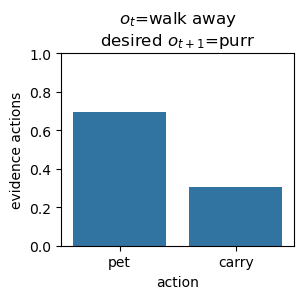

In [26]:
plot_ev_prob_actions = pd.DataFrame({"action": ["pet", "carry"], "evidence actions": evidence_prob_actions})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_ev_prob_actions, x="action", y="evidence actions")
plt.ylim([0,1])
plt.title("$o_{t}$=walk away\ndesired $o_{t+1}$=purr")
plt.show()

So that we get a posterior over which action to choose:

$$p(a_{t}|o_{t}=\text{walk away}, o_{t+1}=\text{purr}) = \begin{pmatrix} 0.69\\ 0.31\end{pmatrix} \begin{matrix} \text{pet}\\ \text{carry} \end{matrix}$$

So we are supposed to choose pet with 69% probability, and carry with 31% probability, if we want to make Schmüffie purr. The noise or uncertainty for this action selection comes from the fact that Schmüffie also has a somewhat high probability of purring even when in a bad mood.


As a side note, this is the same as using Bayes' theorem without the prior and averaging over the predicted state:

$$p(a_{t}|o_{t}=\text{walk away},o_{t+1}=\text{purr}) \propto \sum_{s_{t+1}}p(s_{t+1}|o_{t}=\text{walk away},o_{t+1}=\text{purr}, a_{t})p(a_{t})$$

#### <b> 1.8. Automatic behavior in the prior over actions</b>

 <img src="Action_prior_gen_mod.png" width="200"/>

In the above, we have ignored the prior. However, the prior allows us to learn a priori biases for certain actions. Since Bayesian learning is not the main focus of this document, the introduction to it will be rather short.

Note that all the previous probabilities which we have specified represent some knowledge that we have (learned) about the environment. However, this prior over actions is a probability for something we do with our environment.

As described above, when learning distributions of discrete, categorical variables, as is the case in our examples, Bayesian learning essentially dictates, that a count is kept how often each event has been experienced. In the case of the prior over actions, that simply means counting how often one or the other action was executed, which is divided by the total amount of actions, to get a prior probability of actions. This implements repetition learning.

Importantly, this is independent on the prediction- and evidence-based evaluation we did in the steps above. The prediction- and evidence-based evaluation stays the same, while the prior provides a bias that becomes stronger and stronger with time, which biases action selection in the posterior.

As an example, let's say I have executed pet 50 times, and carry 30 times. Then my prior would be
$$p(a_{t})=\begin{pmatrix} \frac{50}{75}\\ \frac{25}{75}  \end{pmatrix} \begin{matrix} \text{pet}\\ \text{carry} \end{matrix}$$
$$p(a_{t})=\begin{pmatrix} 0.67\\ 0.33  \end{pmatrix} \begin{matrix} \text{pet}\\ \text{carry} \end{matrix}$$
and would bias action selection towards pet.

In [27]:
prior_actions = np.array([0.67, 0.33])

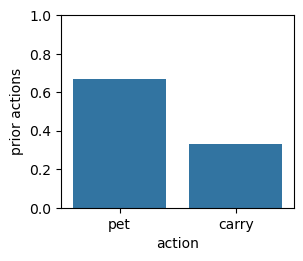

In [28]:
plot_prior_actions = pd.DataFrame({"action": ["pet", "carry"], "prior actions": prior_actions})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_prior_actions, x="action", y="prior actions")
plt.ylim([0,1])
plt.show()

Let's see how this will change action selection.
$$p(a_{t}|o_{t}=\text{walk away},o_{t+1}=\text{purr}) = \text{evidence}*p(a_{t})$$
$$p(a_{t}|o_{t}=\text{walk away},o_{t+1}=\text{purr}) = \sum_{s_{t+1}}p(s_{t+1}|o_{t}=\text{walk away},o_{t+1}=\text{purr}, a_{t})p(a_{t})$$

Where we can plug in the numbers using code

In [29]:
unnormalized_actions_with_prior = evidence_prob_actions*prior_actions

posterior_actions = unnormalized_actions_with_prior / unnormalized_actions_with_prior.sum()

print("posterior over actions after observing walk away, with a habit prior")
print(posterior_actions)

posterior over actions after observing walk away, with a habit prior
[0.82063003 0.17936997]


And plot the values

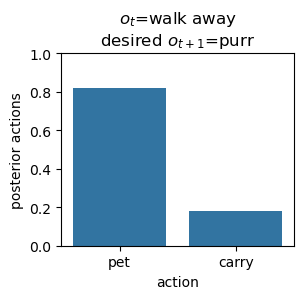

In [30]:
plot_posterior_actions = pd.DataFrame({"action": ["pet", "carry"], "posterior actions": posterior_actions})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_posterior_actions, x="action", y="posterior actions")
plt.ylim([0,1])
plt.title("$o_{t}$=walk away\ndesired $o_{t+1}$=purr")
plt.show()

Since the prior points into the same direction as the prediction-based goal-directed evaluation, it makes action selection more certain.

We can try out different influences of such a prior on action selection. E.g. below with a prior that points in the opposite direction compared to the goal-directed part.

In [31]:
opposite_prior_actions = np.array([0.25, 0.75])

unnormalized_actions_with_prior_opp = unnormalized_prob_actions*opposite_prior_actions

posterior_actions_opp = unnormalized_actions_with_prior_opp / unnormalized_actions_with_prior_opp.sum()

print("posterior over actions after observing walk away, with a habit prior")
print(posterior_actions_opp)

posterior over actions after observing walk away, with a habit prior
[0.42894042 0.57105958]


Plot the values

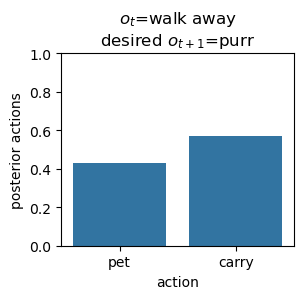

In [32]:
plot_ev_prob_actions_opp = pd.DataFrame({"action": ["pet", "carry"], "posterior actions": posterior_actions_opp})

plt.figure(figsize=[3,2.5])
sns.barplot(data=plot_ev_prob_actions_opp, x="action", y="posterior actions")
plt.ylim([0,1])
plt.title("$o_{t}$=walk away\ndesired $o_{t+1}$=purr")
plt.show()